In [103]:
from plottr.data.datadict_storage import datadict_from_hdf5
from plottr.data.datadict_storage import DataDict, DDH5Writer
from plottr.data.datadict_storage import search_datadict
import numpy as np
import matplotlib.pyplot as plt
import os
from pprint import pprint
from tqdm import tqdm
from datetime import datetime
import pandas as pd
import copy
import itertools
# import scqubits as scq
import csv
from sklearn.decomposition import PCA
from scipy.signal import find_peaks
from lmfit import Model

from scipy.optimize import curve_fit


This notebook is a guide to performing photon tomography using the other .py files in this repository. As always, we define the Fido function for 

In [104]:

basedir = r"D:/Redza/Logs"
show_plots =True
#Fido function to obtain monitr files
def Fido(datetime, name):          #Fido gets your raw _data for you!
    foldername, datadict = search_datadict(basedir, datetime, name=name , newest = True, only_complete=False)
    print(foldername)
    print(datadict)
    return foldername, datadict

Before anything, ensure that:

1) A singular photon emission experiment is run, and a proper looking photon waveform is obtained.
2) The waveform is processed into the mode function accordingly.

Once these two are ensured, run (), which returns the single shot data for all of the standard states.

In [105]:
tomoFolder, tomoDict = Fido("2025-09-25T233803", "tomography_allDensityMatrices")

p_0 = tomoDict['p_0']['values'][0]
q_0 =  tomoDict['q_0']['values'][0]
p_0_vacuum = tomoDict['p_0_vacuum']['values'][0]
q_0_vacuum = tomoDict['q_0_vacuum']['values'][0]

p_1 = tomoDict['p_1']['values'][0]
q_1 =  tomoDict['q_1']['values'][0]
p_1_vacuum = tomoDict['p_1_vacuum']['values'][0]
q_1_vacuum = tomoDict['q_1_vacuum']['values'][0]

p_0plus1 = tomoDict['p_0plus1']['values'][0]
q_0plus1 =  tomoDict['q_0plus1']['values'][0]
p_0plus1_vacuum = tomoDict['p_0plus1_vacuum']['values'][0]
q_0plus1_vacuum = tomoDict['q_0plus1_vacuum']['values'][0]

p_0minus1 = tomoDict['p_0minus1']['values'][0]
q_0minus1 =  tomoDict['q_0minus1']['values'][0]
p_0minus1_vacuum = tomoDict['p_0minus1_vacuum']['values'][0]
q_0minus1_vacuum = tomoDict['q_0minus1_vacuum']['values'][0]

p_0plusi = tomoDict['p_0plusi']['values'][0]
q_0plusi =  tomoDict['q_0plusi']['values'][0]
p_0plusi_vacuum = tomoDict['p_0plusi_vacuum']['values'][0]
q_0plusi_vacuum = tomoDict['q_0plusi_vacuum']['values'][0]

p_0minusi = tomoDict['p_0minusi']['values'][0]
q_0minusi =  tomoDict['q_0minusi']['values'][0]
p_0minusi_vacuum = tomoDict['p_0minusi_vacuum']['values'][0]
q_0minusi_vacuum = tomoDict['q_0minusi_vacuum']['values'][0]



# sort into lists
list_0 = [p_0, q_0, p_0_vacuum, q_0_vacuum]
list_1 = [p_1, q_1, p_1_vacuum, q_1_vacuum]
list_0plus1 = [p_0plus1, q_0plus1, p_0plus1_vacuum, q_0plus1_vacuum]
list_0minus1 = [p_0minus1, q_0minus1, p_0minus1_vacuum, q_0minus1_vacuum]
list_0plusi = [p_0plusi, q_0plusi, p_0plusi_vacuum, q_0plusi_vacuum]
list_0minusi = [p_0minusi, q_0minusi, p_0minusi_vacuum, q_0minusi_vacuum]


2025-09-25T233803_3e59ba77-tomography_allDensityMatrices
p_0: (1, 10000)
  ⌙ shot: (1, 10000)
p_0_vacuum: (1, 10000)
  ⌙ shot: (1, 10000)
p_0minus1: (1, 10000)
  ⌙ shot: (1, 10000)
p_0minus1_vacuum: (1, 10000)
  ⌙ shot: (1, 10000)
p_0minusi: (1, 10000)
  ⌙ shot: (1, 10000)
p_0minusi_vacuum: (1, 10000)
  ⌙ shot: (1, 10000)
p_0plus1: (1, 10000)
  ⌙ shot: (1, 10000)
p_0plus1_vacuum: (1, 10000)
  ⌙ shot: (1, 10000)
p_0plusi: (1, 10000)
  ⌙ shot: (1, 10000)
p_0plusi_vacuum: (1, 10000)
  ⌙ shot: (1, 10000)
p_1: (1, 10000)
  ⌙ shot: (1, 10000)
p_1_vacuum: (1, 10000)
  ⌙ shot: (1, 10000)
q_0: (1, 10000)
  ⌙ shot: (1, 10000)
q_0_vacuum: (1, 10000)
  ⌙ shot: (1, 10000)
q_0minus1: (1, 10000)
  ⌙ shot: (1, 10000)
q_0minus1_vacuum: (1, 10000)
  ⌙ shot: (1, 10000)
q_0minusi: (1, 10000)
  ⌙ shot: (1, 10000)
q_0minusi_vacuum: (1, 10000)
  ⌙ shot: (1, 10000)
q_0plus1: (1, 10000)
  ⌙ shot: (1, 10000)
q_0plus1_vacuum: (1, 10000)
  ⌙ shot: (1, 10000)
q_0plusi: (1, 10000)
  ⌙ shot: (1, 10000)
q_0plusi_vacu

We plot out each set of p and q-squeezed data, and perform PCA corrections for each of them to align them with the IQ axes.

In [106]:
#plotter function
def Plot(p, q):
    squeezed_p = p
    squeezed_q = q

    plt.figure(figsize = [5,5])
    plt.scatter(squeezed_p.real, squeezed_p.imag, s = 0.1,label='Squeezed in p')
    plt.scatter(squeezed_q.real, squeezed_q.imag, s = 0.1,label='Squeezed in q')
    # plt.xlim([-1e-9,1e-9])
    # plt.ylim([-1e-9,1e-9])
    plt.xlabel("In-phase (I)")
    plt.ylabel("Quadrature (Q)")
    plt.legend()
    plt.title('IQ plot')
    plt.show()


#PCA angle corrector function to determine alignment axes
def pca_quadrature_corrector(squeezed_p):
    data_IQ = np.array([squeezed_p.real, squeezed_p.imag]).T
    pca = PCA(n_components=2)
    pca.fit(data_IQ)
    # print(pca.components_.T)
    eigenvec = pca.components_.T[:, 0]
    theta = np.arctan(eigenvec[1]/eigenvec[0])

    return theta

#projection function
def ProjectPQ(p, q):
    projected_p = np.real(p)
    projected_q = np.imag(q)

    return projected_p, projected_q


def Normalization(list):        #list in the format of [p, q, p_vacuum, q_vacuum]
    normalized_p = (list[0] - np.mean(list[2]))/(list[2].std() * np.sqrt(2))
    normalized_q = (list[1] - np.mean(list[3]))/(list[3].std() * np.sqrt(2))

    return normalized_p, normalized_q

#calculation of density matrices
#the pauli matrices

pauli_i = np.array([[1,0],[0,1]])
pauli_x =np.array([[0,1],[1,0]])
pauli_y =np.array([[0,-1j],[1j,0]])
pauli_z = np.array([[1,0],[0,-1]])


def XYZMatrices(squeezed_p, squeezed_q):
    p_bar = np.mean(squeezed_p)
    q_bar = np.mean(squeezed_q)

    p2_bar = np.mean([p**2 for p in squeezed_p])
    q2_bar = np.mean([q**2 for q in squeezed_q])

    #calculating Pauli matrix expectation values
    X_bar = np.sqrt(2) * q_bar
    Y_bar = np.sqrt(2) * p_bar
    Z_bar = 2 - q2_bar - p2_bar

    DensityMatrix = 0.5 * (pauli_i + X_bar * pauli_x + Y_bar * pauli_y + Z_bar * pauli_z)

    return X_bar, Y_bar, Z_bar, DensityMatrix
    

# print(list_0)


Now, to process the data.

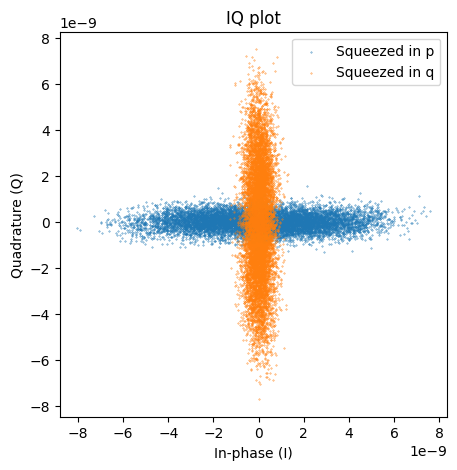

[[ 0.96569221+0.j         -0.01120246-0.00821864j]
 [-0.01120246+0.00821864j  0.03430779+0.j        ]]
trace check = (1+0j)
[[9.32333594e-01+0.j         3.11565134e-06+0.01082385j]
 [3.11565134e-06-0.01082385j 6.76664061e-02+0.j        ]]
trace check = (1+0j)
[[0.94728245+0.j         0.006365  +0.00715777j]
 [0.006365  -0.00715777j 0.05271755+0.j        ]]
trace check = (1+0j)
[[0.94866792+0.j         0.00175134+0.01485304j]
 [0.00175134-0.01485304j 0.05133208+0.j        ]]
trace check = (1+0j)
[[0.93580296+0.j         0.00103455-0.01333813j]
 [0.00103455+0.01333813j 0.06419704+0.j        ]]
trace check = (1+0j)
[[0.94346895+0.j         0.00831414+0.00387322j]
 [0.00831414-0.00387322j 0.05653105+0.j        ]]
trace check = (1+0j)


In [107]:
#First, PCA to correct for the angles
aligned_lists = []
for elem in [list_0, list_1, list_0plus1, list_0minus1, list_0plusi, list_0minusi]:
    list_out = []
    theta = pca_quadrature_corrector(elem[0])
    for i in range(len(elem)):
       elem[i] = elem[i] * np.exp(-1j * theta)
       list_out.append(i)
    aligned_lists.append(list_out)



Plot(list_1[0], list_1[1])

#Next, loop to normalize data

for elem in [list_0, list_1, list_0plus1, list_0minus1, list_0plusi, list_0minusi]:
    p,q = Normalization(elem)
    elem.append(p)
    elem.append(q)

#next, project the data
for elem in [list_0, list_1, list_0plus1, list_0minus1, list_0plusi, list_0minusi]:
    projected_p, projected_q = ProjectPQ(elem[-2], elem[-1])
    elem.append(projected_p)
    elem.append(projected_q)

#finally, determine density matrices
for elem in [list_0, list_1, list_0plus1, list_0minus1, list_0plusi, list_0minusi]:
    x,y,z, rho = XYZMatrices(elem[-2],elem[-1])
    print(rho)
    print(f'trace check = {rho[0][0] + rho[1][1]}')
    
